Nicolas Brandstetter
Felipe Keim

Predicción de inicio y final de un evento de huso del sueño

In [ ]:
#Imports
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import os
import sys
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import math 
from IPython.display import clear_output 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# loading data

In [ ]:
!unzip "/content/drive/MyDrive/Cursos/Primavera 2022/Inteligencia/Proyecto/Data/Localización de husos sigma.zip" -d "/content/data"
clear_output() 
print('****Base de datos descomprimida****')

****Base de datos descomprimida****


In [ ]:
test_marks    = np.load('data/Localización de husos sigma en el EEG del sueño/test_marks.npy')
test_signals  = np.load('data/Localización de husos sigma en el EEG del sueño/test_signals.npy')
train_marks   = np.load('data/Localización de husos sigma en el EEG del sueño/train_marks.npy')
train_signals = np.load('data/Localización de husos sigma en el EEG del sueño/train_signals.npy')
val_marks     = np.load('data/Localización de husos sigma en el EEG del sueño/val_marks.npy')
val_signals   = np.load('data/Localización de husos sigma en el EEG del sueño/val_signals.npy')

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(np.concatenate((test_signals,train_signals,val_signals)))

val_signals_normalized = scaler.transform(val_signals)
test_signals_normalized = scaler.transform(test_signals)
train_signals_normalized = scaler.transform(train_signals)

In [ ]:
val_marks = torch.tensor(val_marks)
test_marks = torch.tensor(test_marks)
train_marks = torch.tensor(train_marks)

val_signals = torch.tensor(val_signals_normalized)
test_signals = torch.tensor(test_signals_normalized)
train_signals = torch.tensor(train_signals_normalized)

## Creating Dataset

In [ ]:
train_ds = torch.utils.data.TensorDataset(train_signals, train_marks)
val_ds = torch.utils.data.TensorDataset(val_signals, val_marks)
test_ds = torch.utils.data.TensorDataset(test_signals, test_marks)

# entrenamiento y visualización

## Curves

In [ ]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()
    plt.show()


## IOU

In [ ]:
SMOOTH = 1e-6

def iou_pytorch(y_predicted: torch.Tensor, y_vals: torch.Tensor):

    largo=len(y_vals)
    error_array=np.zeros(largo)
    count=0
    for pred,y_val in zip(y_predicted,y_vals):
        pred=pred.squeeze(0)
        intervalo_inter = [max(pred[0],y_val[0]),min(pred[1],y_val[1])]
        rest = intervalo_inter[1] - intervalo_inter[0]
        inter = rest if rest>0 else 0

        len_predicted = pred[1] - pred[0]
        len_val = y_val[1] - y_val[0]
        union = len_predicted + len_val - inter
        error_array[count]=(inter/(union+1e-6))
        count+=1
        
    return torch.tensor(error_array)

## Evaluation

In [ ]:
def evaluate(val_loader, model, criterion, use_gpu,delta):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0
    y_predicted=[]
    error_list=[]
    #delta=math.sqrt(delta)
    for x_val, y_val in val_loader:
        for x,y in zip(x_val,y_val):   
            x=x.unsqueeze(0)
            x=x.unsqueeze(0)
            if use_gpu:
                x = x.cuda()
                y = y.cuda()
            y_pred=model(x)
            y_pred=y_pred.reshape(2)
            #print('y_pred.unsqueeze(0)', y_pred.unsqueeze(0))
            #print('y.unsqueeze(0)', y.unsqueeze(0))
            err = criterion(y_pred.unsqueeze(0),y.unsqueeze(0)) ###,eva=True)   
            error_list.append(err)
            y_predicted.append(y_pred)
            IoU = iou_pytorch(y_pred.unsqueeze(0), y.unsqueeze(0))
            cumulative_predictions += int(IoU>delta)
            cumulative_loss += err
        data_count = x_val.shape[0]

    val_acc = cumulative_predictions / data_count  #data_count = len(y_val)
    val_loss = cumulative_loss/len(y_val)
    return val_acc, val_loss

## Training set up

### Train step 

In [ ]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu,delta):

    #delta=math.sqrt(delta)
    y_predicted = model(x_batch.unsqueeze(1))     ### DIM (batch_size, channels, data_len)
    #print('antes:', y_predicted)
    #y_predicted = y_predicted.int().float()
    #y_predicted = torch.tensor(y_predicted, requires_grad=True)
    #y_predicted.requires_grad_(True)
    
    #print('despues:', y_predicted)

    # Cálculo de loss
    #print('y_predicted.squeeze(): ', y_predicted.squeeze())
    #print('y_batch.float(): ', y_batch.float())
    
    loss = criterion(y_predicted.squeeze(), y_batch.float())   ### y_predicted e y_batch DEBEN TENER IGUAL DIM
    #IoU = iou_pytorch(y_predicted.squeeze(), y_batch.float())
    # Calculo de VP
    #VP = sum(IoU>delta)    #entrega un tensor con la cantidad de valores predichos correctmente

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ####
    #Postprocesamiento:
    #y_predicted = torch.round(y_predicted)
    #y_predicted = torch.sort(y_predicted)

    #print(y_predicted)
    #if y_predicted[0] < 0: y_predicted[0] = 0
    #if y_predicted[1] > 800: y_predicted[1] = 800
    ####

    return y_predicted, loss

### Train Model

In [ ]:
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
    delta=0.1
):

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # for i,x in enumerate(train_loader):
    #     a=[0,1,2,3,4]
    #     if i in a:
    #         print("loader: ",x[1])

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0


        # Entrenamiento del modelo
        model.train()

        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu, delta)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            #class_prediction = torch.argmax(y_predicted, axis=1).long()
            IoU = iou_pytorch(y_predicted, y_batch)
            VP = sum(IoU>delta).item()
            cumulative_train_corrects += VP

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")
                #print('predichos: ', y_predicted[0])
                #print('reales: ', y_batch[0])
            iteration += 1


        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu, delta)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count   #multiplique por 4 por ahora

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    # if data_augmentation:
    #     train_dataset.dataset.transform = original_transform

    return curves

# Models Definition

## Conv1dModel

In [ ]:
class CNN1d_Model(nn.Module):
    eva=False
    def __init__(
        self,
        dropout_p,
        input_size=1,
    ):
        
        super().__init__()
        self.conv_blocks = nn.Sequential(
            
            nn.Conv1d(input_size, 1, kernel_size=1, stride=1, padding="same"),

            nn.Conv1d(input_size, 8, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(8, 16,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16,32,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32,64,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64,128,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(5),

            nn.Conv1d(256,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(5),

            nn.Conv1d(256,2,kernel_size=3, stride = 1, padding="same"),
            
        )

    def forward(self, x,evaa=False):
        return self.conv_blocks(x)

# Training

In [ ]:
lr = 0.005
batch_size = 64
#criterion = iou_pytorch
criterion = torch.nn.MSELoss()
epochs = 60

Epoch 1/60
Iteration 11 - Batch 11/70 - Train loss: 113574.96630859375, Train acc: 0.009114583333333334
Iteration 22 - Batch 22/70 - Train loss: 81026.21127717392, Train acc: 0.01154891304347826
Iteration 33 - Batch 33/70 - Train loss: 61110.37333409926, Train acc: 0.021599264705882353
Iteration 44 - Batch 44/70 - Train loss: 49581.50444878472, Train acc: 0.03125
Iteration 55 - Batch 55/70 - Train loss: 42295.49965122768, Train acc: 0.03822544642857143
Iteration 66 - Batch 66/70 - Train loss: 37237.9521484375, Train acc: 0.040345149253731345
Val loss: 10397.693359375, Val acc: 0.07577433628318585
Epoch 2/60
Iteration 81 - Batch 11/70 - Train loss: 11195.925944010416, Train acc: 0.07421875
Iteration 92 - Batch 22/70 - Train loss: 11021.921238111414, Train acc: 0.07404891304347826
Iteration 103 - Batch 33/70 - Train loss: 11010.212833180147, Train acc: 0.07628676470588236
Iteration 114 - Batch 44/70 - Train loss: 10884.695052083332, Train acc: 0.07743055555555556
Iteration 125 - Batch 55

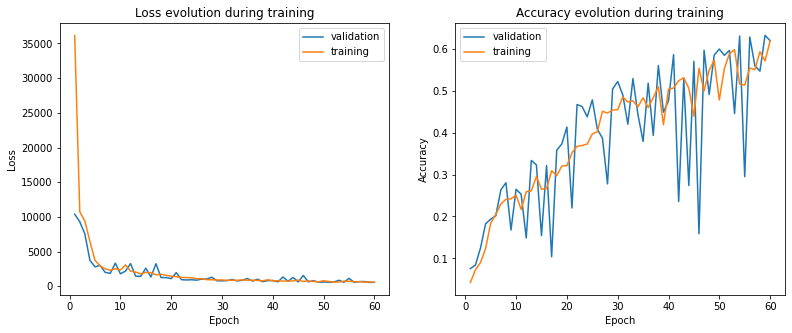

In [ ]:
CNN1d = CNN1d_Model(dropout_p=0.5)
curves = train_model(
    CNN1d,
    train_ds,
    val_ds,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=False,
    data_augmentation=False,
    delta=0.8
)
show_curves(curves)

In [ ]:
predicciones = CNN1d(test_signals.unsqueeze(1)[:4]).detach()

In [ ]:
test_marks[:4]

tensor([[260, 367],
        [333, 515],
        [353, 557],
        [339, 468]], dtype=torch.int32)

In [ ]:
test_signals[:4]

tensor([[ 1.9681,  2.0839,  2.0762,  ...,  1.1190,  1.1550,  1.1421],
        [-0.5977, -0.6917, -0.6780,  ..., -0.5319, -0.5520, -0.5542],
        [-0.2456, -0.1528, -0.0978,  ...,  0.5365,  0.5234,  0.4473],
        [ 0.8895,  0.7770,  0.5895,  ..., -0.0921, -0.1309, -0.1070]])

In [ ]:
train_ds = torch.utils.data.TensorDataset(train_signals, train_marks)
val_ds = torch.utils.data.TensorDataset(val_signals, val_marks)
test_ds = torch.utils.data.TensorDataset(test_signals, test_marks)
a=np.load('data_sigma_spindles/train_signals.npy')
b=np.load('data_sigma_spindles/train_marks.npy')
t=np.arange(len(a[0]))*(4/800)
plt.plot(t,a[0])
plt.vlines(b[0]*(4/800),-40,40,colors="r")

print(train_ds[0][1])

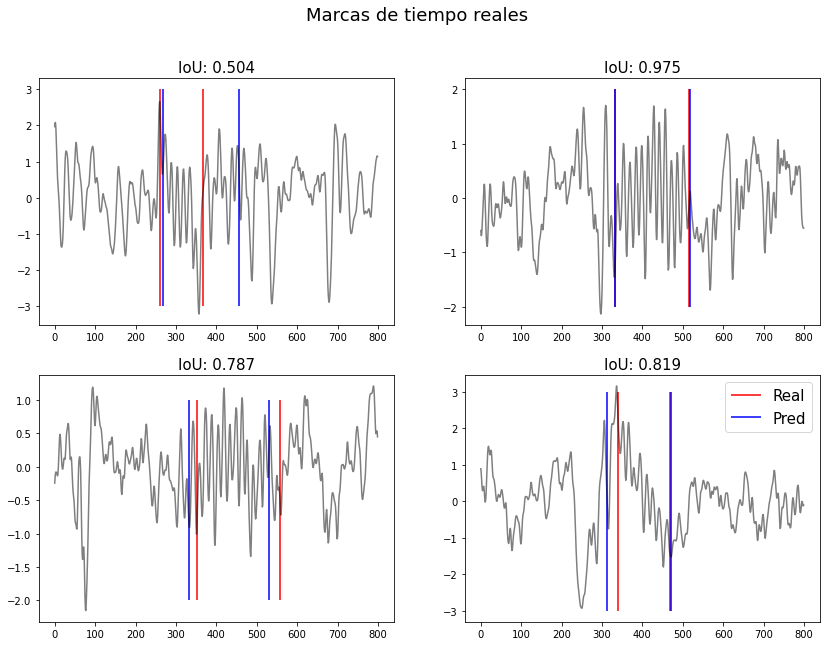

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))

t = np.arange(800)
axs[0, 0].plot(t, test_signals[0], c='black', alpha=0.5)
l1 = axs[0, 0].vlines(test_marks[0], -3, 3, colors='r')
l2 = axs[0, 0].vlines(predicciones[0], -3, 3, colors='b')
axs[0, 0].set_title('IoU: ' + str(round(iou_pytorch(test_marks[0].unsqueeze(0),predicciones[0].unsqueeze(0)).item(),3)), size=15)

axs[0, 1].plot(t, test_signals[1], c='black', alpha=0.5)
axs[0, 1].vlines(test_marks[1], -2, 2, colors='r')
axs[0, 1].vlines(predicciones[1], -2, 2, colors='b')
axs[0, 1].set_title('IoU: ' + str(round(iou_pytorch(test_marks[1].unsqueeze(0),predicciones[1].unsqueeze(0)).item(),3)), size=15)

axs[1, 0].plot(t, test_signals[2], c='black', alpha=0.5)
axs[1, 0].vlines(test_marks[2], -2, 1, colors='r')
axs[1, 0].vlines(predicciones[2], -2, 1, colors='b')
axs[1, 0].set_title('IoU: ' + str(round(iou_pytorch(test_marks[2].unsqueeze(0),predicciones[2].unsqueeze(0)).item(),3)), size=15)

plt.legend([l1, l2],["HHZ 1", "HHN"])

axs[1, 1].plot(t, test_signals[3], c='black', alpha=0.5)
axs[1, 1].vlines(test_marks[3], -3, 3, colors='r')
axs[1, 1].vlines(predicciones[3], -3, 3, colors='b')
axs[1, 1].set_title('IoU: ' + str(round(iou_pytorch(test_marks[3].unsqueeze(0),predicciones[3].unsqueeze(0)).item(),3)), size=15)

plt.legend([l1, l2],["Real", "Pred"], prop={'size': 15})
fig.suptitle('Marcas de tiempo reales', fontsize=18)
fig.show()

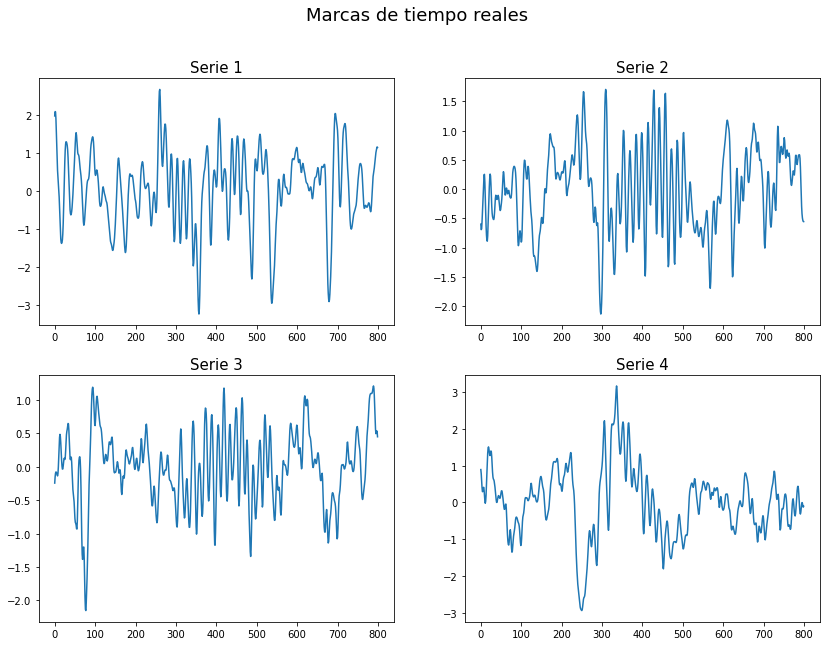

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))

t = np.arange(800)
axs[0, 0].plot(t, test_signals[0])
#axs[0, 0].vlines(test_marks[0], -3, 3, colors='r')
#axs[0, 0].vlines(predicciones[0], -3, 3, colors='black')
axs[0, 0].set_title('Serie 1', size=15)

axs[0, 1].plot(t, test_signals[1])
#axs[0, 1].vlines(test_marks[1], -2, 2, colors='r')
#axs[0, 1].vlines(predicciones[1], -2, 2, colors='black')
axs[0, 1].set_title('Serie 2', size=15)

axs[1, 0].plot(t, test_signals[2])
#axs[1, 0].vlines(test_marks[2], -2, 1, colors='r')
#axs[1, 0].vlines(predicciones[2], -2, 1, colors='black')
axs[1, 0].set_title('Serie 3', size=15)

axs[1, 1].plot(t, test_signals[3])
#axs[1, 1].vlines(test_marks[3], -3, 3, colors='r')
#axs[1, 1].vlines(predicciones[3], -3, 3, colors='black')
axs[1, 1].set_title('Serie 4', size=15)

fig.suptitle('Marcas de tiempo reales', fontsize=18)
fig.show()